## Step 2: Classifier

Develop a classifier for two categories. Create the necessary folders for the test and train datasets. Either create your own model or tranfer a model and revise it. Make sure you incorporate regularization, callbacks, etc., and use data augmentation. Since images may not be so distinct with respect to their categories, you may not get the same kind of performance you had in your assignments.


In [2]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import ResNet18_Weights
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from PIL import Image
from collections import deque
from pathlib import Path
import logging, os, glob
from sklearn.model_selection import train_test_split
from _logging import set_logging
from _metrics import display_metrics
from _pckle import save_pickle_object, load_pickle_object
from _utility import gl, get_perc, get_dictionaries_from_list
from _model import train_model

set_logging(logging)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
classes = ["Business", "Other"]
dict_classes, dict_classes_rev = get_dictionaries_from_list(classes)


In [4]:
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size = 4

In [5]:
def imshow(inp, _mean, _std, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(_mean)
    std = np.array(_std)
    inp = std * inp + mean  # denormalise
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [6]:
_mean = [0.4363, 0.4328, 0.1291]
_std = [0.2129, 0.2075, 0.2038]
_transform = transforms.Compose(
    [transforms.Resize([IMAGE_WIDTH, IMAGE_HEIGHT]),
     transforms.ToTensor(),
     transforms.Normalize(torch.Tensor(_mean), torch.Tensor(_std))]
)
_dataset = datasets.ImageFolder(root="Images", transform=_transform)
size = _dataset.__len__()
test_size = int(size * 0.05)
new_size = size - test_size
train_size = int(new_size * 0.8)
val_size = new_size - train_size
train_dataset, val_dataset, test_dataset = random_split(_dataset, lengths=[train_size, val_size, test_size])
train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset = val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, shuffle=True)

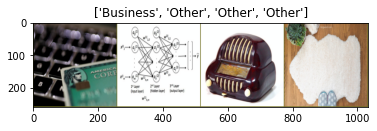

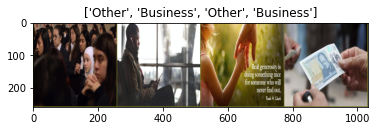

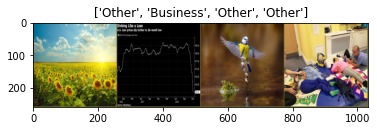

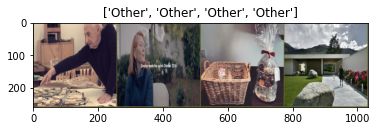

In [7]:
for i in range(4):
    # Get a batch of training data
    inputs, labels = next(iter(train_loader))
    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)
    imshow(out, _mean, _std, title=[classes[x] for x in labels])

In [8]:
def visualize_model(model, dataloaders, classes, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
dataloaders = {"train": train_loader, "val": val_loader}
model_ft = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(classes))
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)